## Spotify world wide streaming data ARIMA model

### Hypothesis
##### 0.1 - The tendency of song list
##### 0.2 - Uncover data charactertics, how to become Top1 
##### 0.3 The degree of linking between Countries
##### 0.4 Arima model to predict tomorrow's streams

### EDA
##### 1.1 - How many Nulls ? Does the data skewed?
##### 1.2 - Number of Steamers per Month
##### 1.3 - Type of Top1

### Song Charasteristic (World)
##### 2.1 - Go to Red Velvet, Peek-A-Boo! 
##### 2.2 - Top Singer : Ed Sheeran
##### 2.3 - Seaonal Song
##### 2.4 - Emotional Song  

### Song Characterisitc (by Country)
##### 3.1 - Japan Chart
##### 3.2 - Intersected USA Chart & Other Country

### Modeling

##### 4.1 - ARIMA, Setting Basic Parameter 
##### 4.2 - ARIMA, Best Fit Model to Train Set
##### 4.3 - ARIMA, Best Fit Model to Test Set
##### 4.4 - ARIMA, with X Variable -exog-

#### Material
1. List of Countries https://gist.github.com/frankkienl/a594807bf0dcd23fdb1b
2. Peek-A-Boo, Youtube: https://www.youtube.com/watch?v=6uJf2IT2Zh8  
3. Positive Word List: http://positivewordsresearch.com/list-positive-emotion-words/  
4. ARIMA Model Python: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
5. ARIMA Model Parameter Fitting: https://people.duke.edu/~rnau/411arim.htm
6. ARIMA Seasonal Parameter: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error as mse
pd.options.mode.chained_assignment = None

/Users/mwhite/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_train = pd.read_csv('./input/data.csv')
positive_word = pd.read_excel('./input/positive_words.xlsx', header = None)
df_feature = pd.read_csv('./input/featuresdf.csv')
positive_word.columns = ['char', 'word_set']
positive_word['word_set'] = positive_word['word_set'].apply(lambda r: set([word.strip().lower() for word in r.split(',')]))
print('Column List {}'.format(df_train.columns.tolist()))
print('There are # row {}, #col {}'.format(df_train.shape[0], df_train.shape[1]))
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.loc[df_train.Date.dt.year == 2017,:]
df_train['month'] = df_train.Date.dt.month
df_train['day'] = df_train.Date.dt.day
df_train['dayofweek'] = df_train.Date.dt.dayofweek
print('-------------------------------------------------------')
print('Positive Word sample')
print(positive_word.sample(1))

Column List ['Position', 'Track Name', 'Artist', 'Streams', 'URL', 'Date', 'Region']
There are # row 3441197, #col 7
-------------------------------------------------------
Positive Word sample
   char                                           word_set
22    W  {willing, will, welfare, wonderful, warmth, wo...


In [3]:
list_country = [{"AD", "Andorra"},
            {"AE", "United Arab Emirates"},
            {"AF", "Afghanistan"},
            {"AG", "Antigua and Barbuda"},
            {"AI", "Anguilla"},
            {"AL", "Albania"},
            {"AM", "Armenia"},
            {"AO", "Angola"},
            {"AQ", "Antarctica"},
            {"AR", "Argentina"},
            {"AS", "American Samoa"},
            {"AT", "Austria"},
            {"AU", "Australia"},
            {"AW", "Aruba"},
            {"AX", "Åland Islands"},
            {"AZ", "Azerbaijan"},
            #B
            {"BA", "Bosnia and Herzegovina"},
            {"BB", "Barbados"},
            {"BD", "Bangladesh"},
            {"BE", "Belgium"},
            {"BF", "Burkina Faso"},
            {"BG", "Bulgaria"},
            {"BH", "Bahrain"},
            {"BI", "Burundi"},
            {"BJ", "Benin"},
            {"BL", "Saint Barthélemy"},
            {"BM", "Bermuda"},
            {"BN", "Brunei Darussalam"},
            {"BO", "Bolivia, Plurinational State of"},
            {"BQ", "Bonaire, Sint Eustatius and Saba"},
            {"BR", "Brazil"},
            {"BS", "Bahamas"},
            {"BT", "Bhutan"},
            {"BV", "Bouvet Island"},
            {"BW", "Botswana"},
            {"BY", "Belarus"},
            {"BZ", "Belize"},
            #C
            {"CA","Canada"},
            {"CC","Cocos (Keeling) Islands"},
            {"CD","Congo, the Democratic Republic of"},
            {"CF","Central African Republic"},
            {"CG","Congo"},
            {"CH","Switzerland"},
            {"CI","Côte d'Ivoire"},
            {"CK","Cook Islands"},
            {"CL","Chile"},
            {"CM","Cameroon"},
            {"CN","China"},
            {"CO","Colombia"},
            {"CR","Costa Rica"},
            {"CU","Cuba"},
            {"CV","Cabo Verde"},
            {"CW","Curaçao"},
            {"CX","Christmas Island"},
            {"CY","Cyprus"},
            {"CZ","Czech Republic"},
            #D
            {"DE","Germany"},
            {"DJ","Djibouti"},
            {"DK","Denmark"},
            {"DM","Dominica"},
            {"DO","Dominican Republic"},
            {"DZ","Algeria"},
            #E
            {"EC","Ecuador"},
            {"EE","Estonia"},
            {"EG","Egypt"},
            {"EH","Western Sahara"},
            {"ER","Eritrea"},
            {"ES","Spain"},
            {"ET","Ethiopia"},
            #F
            {"FI","Finland"},
            {"FJ","Fiji"},
            {"FK","Falkland Islands (Malvinas)"},
            {"FM","Micronesia, Federated States of"},
            {"FO","Faroe Islands"},
            {"FR","France"},
            #G
            {"GA","Gabon"},
            {"GB","United Kingdom of Great Britain and Northern Ireland"},
            {"GD","Grenada"},
            {"GE","Georgia"},
            {"GF","French Guiana"},
            {"GG","Guernsey"},
            {"GH","Ghana"},
            {"GI","Gibraltar"},
            {"GL","Greenland"},
            {"GM","Gambia"},
            {"GN","Guinea"},
            {"GP","Guadeloupe"},
            {"GQ","Equatorial Guinea"},
            {"GR","Greece"},
            {"GS","South Georgia and the South Sandwich Islands"},
            {"GT","Guatemala"},
            {"GU","Guam"},
            {"GW","Guinea-Bissau"},
            {"GY","Guyana"},
            #H
            {"HK","Hong Kong"},
            {"HM","Heard Island and McDonalds Islands"},
            {"HN","Honduras"},
            {"HR","Croatia"},
            {"HT","Haiti"},
            {"HU","Hungary"},
            #I
            {"ID","Indonesia"},
            {"IE","Ireland"},
            {"IL","Israel"},
            {"IM","Isle of Man"},
            {"IN","India"},
            {"IO","British Indian Ocean Territory"},
            {"IQ","Iraq"},
            {"IR","Iran, Islamic Republic of"},
            {"IS","Iceland"},
            {"IT","Italy"},
            #J
            {"JE","Jersey"},
            {"JM","Jamaica"},
            {"JO","Jordan"},
            {"JP","Japan"},
            #K
            {"KE","Kenya"},
            {"KG","Kyrgyzstan"},
            {"KH","Cambodia"},
            {"KI","Kiribati"},
            {"KM","Comoros"},
            {"KN","Saint Kitts and Nevis"},
            {"KP","Korea, Democratic People's Republic of"},
            {"KR","Korea, Republic of"},
            {"KW","Kuwait"},
            {"KY","Cayman Islands"},
            {"KZ","Kazakhstan"},
            #L
            {"LA","Lao People's Democratic Republic"},
            {"LB","Lebanon"},
            {"LC","Saint Lucia"},
            {"LI","Liechtenstein"},
            {"LK","Sri Lanka"},
            {"LR","Liberia"},
            {"LS","Lesotho"},
            {"LT","Lithuania"},
            {"LU","Luxembourg"},
            {"LV","Latvia"},
            #M
            {"MA","Morocco"},
            {"MC","Monaco"},
            {"MD","Moldova, Republic of"},
            {"ME","Montenegro"},
            {"MF","Saint Martin (French part)"},
            {"MG","Madagascar"},
            {"MH","Marshall Islands"},
            {"MK","Macedonia, the former Yugoslav Republic of"},
            {"ML","Mali"},
            {"MM","Myanmar"},
            {"MN","Mongolia"},
            {"MO","Macao"},
            {"MP","Northern Mariana Islands"},
            {"MQ","Martinique"},
            {"MR","Mauritania"},
            {"MS","Montserrat"},
            {"MT","Malta"},
            {"MU","Mauritius"},
            {"MV","Maldives"},
            {"MW","Malawi"},
            {"MX","Mexico"},
            {"MY","Malaysia"},
            {"MZ","Mozambique"},
            #N
            {"NA","Namibia"},
            {"NC","New Caledonia"},
            {"NE","Niger"},
            {"NF","Norfolk Island"},
            {"NG","Nigeria"},
            {"NI","Nicaragua"},
            {"NL","Netherlands"},
            {"NO","Norway"},
            {"NP","Nepal"},
            {"NR","Nauru"},
            {"NU","Niue"},
            {"NZ","New Zealand"},
            #O
            {"OM","Oman"},
            #P
            {"PA","Panama"},
            {"PE","Peru"},
            {"PF","French Polynesia"},
            {"PG","Papua New Guinea"},
            {"PH","Philippines"},
            {"PK","Pakistan"},
            {"PL","Poland"},
            {"PM","Saint Pierre and Miquelon"},
            {"PN","Pitcairn"},
            {"PR","Puerto Rico"},
            {"PS","Palestine, State of"},
            {"PT","Portugal"},
            {"PW","Palau"},
            {"PY","Paraguay"},
            #Q
            {"QA","Qatar"},
            #R
            {"RE","Réunion"},
            {"RO","Romania"},
            {"RS","Serbia"},
            {"RU","Russian Federation"},
            {"RW","Rwanda"},
            #S
            {"SA","Saudi Arabia"},
            {"SB","Solomon Islands"},
            {"SC","Seychelles"},
            {"SD","Sudan"},
            {"SE","Sweden"},
            {"SG","Singapore"},
            {"SH","Saint Helena, Ascension and Tristan da Cunha"},
            {"SI","Slovenia"},
            {"SJ","Svalbard and Jan Mayen"},
            {"SK","Slovakia"},
            {"SL","Sierra Leone"},
            {"SM","San Marino"},
            {"SN","Senegal"},
            {"SO","Somalia"},
            {"SR","Suriname"},
            {"SS","South Sudan"},
            {"ST","Sao Tome and Principe"},
            {"SV","El Salvador"},
            {"SX","Sint Maarten (Dutch part)"},
            {"SY","Syrian Arab Republic"},
            {"SZ","Swaziland"},
            #T
            {"TC","Turks and Caicos Islands"},
            {"TD","Chad"},
            {"TF","French Southern Territories"},
            {"TG","Togo"},
            {"TH","Thailand"},
            {"TJ","Tajikistan"},
            {"TK","Tokelau"},
            {"TL","Timor-Leste"},
            {"TM","Turkmenistan"},
            {"TN","Tunisia"},
            {"TO","Tonga"},
            {"TR","Turkey"},
            {"TT","Tuvalu"},
            {"TW","Taiwan, Province of China"},
            {"TZ","Tanzania, United Republic of"},
            #U
            {"UA","Ukraine"},
            {"UG","Uganda"},
            {"UM","United States Minor Outlying Islands"},
            {"US","United States of America"},
            {"UY","Uruguay"},
            {"UZ","Uzbekistan"},
            #V
            {"VA","Holy See"},
            {"VC","Saint Vincent and the Grenadines"},
            {"VE","Venezuela, Bolivarian Republic of"},
            {"VG","Virgin Islands, British"},
            {"VI","Virgin Islands, U.S."},
            {"VN","Viet Nam"},
            {"VU","Vanuatu"},
            #W
            {"WF","Wallis and Futuna"},
            {"WS","Samoa"},
            #Y
            {"YE","Yemen"},
            {"YT","Mayotte"},
            #Z
            {"ZA","South Africa"},
            {"ZM","Zambia"},
            {"ZW","Zimbabwe"}]
dict_count = {(full.lower() if len(abv) > len(full) else abv.lower()) : (abv if len(abv) > len(full) else full)   for abv, full in list_country}
df_train['Region_full'] = df_train['Region'].map(dict_count)

## 1. EDA
Nulls, skewness?

In [4]:
print('Column has Null Value?')
print(df_train.columns[df_train.isnull().any()].tolist())
df_tmp = df_train[['Track Name', 'Artist', 'URL']].fillna('None')
df_train.dropna(inplace =True)
tot = df_tmp.shape[0]
ref = {}
for i, name in enumerate(['Track Name', 'Artist', 'URL']):
    none_cnt = (df_tmp[name] == 'None').sum()
    ref[name] = [tot-none_cnt, none_cnt]
ref = pd.DataFrame(ref)
ref.iloc[1,:] / tot

Column has Null Value?
['Track Name', 'Artist', 'URL', 'Region_full']


Artist        0.000196
Track Name    0.000196
URL           0.000002
Name: 1, dtype: float64

In [5]:
# Most nulls have no data, dropping them.
df_train.dropna(inplace = True)

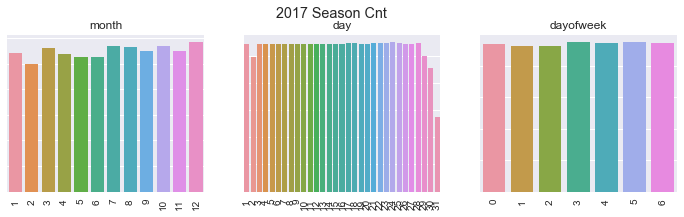

In [6]:
# Is data skewed by month?
plt.figure(figsize = (12,3))
i = 1
df_tmp = df_train.loc[df_train.Date.dt.year == 2017,:]
for col in ['month', 'day', 'dayofweek']:
    ax = plt.subplot(1,3,i)
    cnt = df_tmp[col].value_counts()
    cnt.sort_index(inplace= True)
    sns.barplot(cnt.index, cnt.values, ax = ax)
    ax.set_title(col)
    ax.set_yticklabels('')
    ax.tick_params('x', rotation = 90)
    i += 1
plt.subplots_adjust(hspace = 0.2, top = 0.85)
plt.suptitle('2017 Season Cnt')
plt.show()

No standout month. 
Day 2 drop.  
Not all months have 31 days.  
Day of week irrelevant.

## 2. Number of Streams

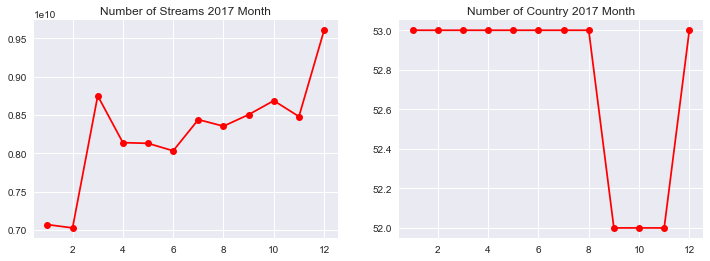

In [7]:
month_user = df_train.loc[df_train.Date.dt.year == 2017,:].groupby('month')['Streams'].sum().to_frame()
f, ax =plt.subplots(1,2,figsize = (12,4))
ax[0].plot(np.arange(1,13), month_user['Streams'], '-ro')
ax[0].set_title('Number of Streams 2017 Month')
country_per_month = df_train.loc[df_train.Date.dt.year == 2017,:].groupby('month')['Region'].nunique().to_frame()
ax[1].plot(np.arange(1,13), country_per_month['Region'], '-ro')
ax[1].set_title('Number of Country 2017 Month')
plt.show()

## 3. Sort of Top1

In [8]:
us_song = df_train.loc[df_train.Region == 'us',:]
df_stream = us_song[['Date', 'Track Name', 'Streams', 'Position']]
df_stream = df_stream.groupby(['Date', 'Track Name']).first().reset_index()
stream_num = df_stream.pivot(index = 'Date', columns = 'Track Name', values = 'Streams')
pos_num = df_stream.pivot(index = 'Date', columns = 'Track Name', values = 'Position')
us_unique_song = us_song['Track Name'].loc[us_song.Position == 1].unique()

def draw_stream_pos(us_unique_song, i, type_):
    song = us_unique_song[i]
    song_stream = stream_num.loc[:,song]
    song_pos = pos_num.loc[:,song]
    tmp = song_stream.loc[song_stream.notnull()]
    tmp2 = song_pos.loc[song_stream.notnull()]
    first = (tmp2.values == 1)
    not_first = ~first
    f, ax = plt.subplots(1,2,figsize = (12,4))
    ax[0].scatter(tmp.index[not_first], tmp.values[not_first], alpha = 0.4, color = 'grey')
    ax[0].scatter(tmp.index[first], tmp.values[first], color = 'red')
    ax[1].scatter(tmp2.index[not_first], tmp2.values[not_first], alpha = 0.4, color = 'grey')
    ax[1].scatter(tmp2.index[first], tmp2.values[first], color = 'red')
    ax[1].invert_yaxis()
    ax[1].set_title('Top1 Number : '+ str((tmp2.values == 1).sum()))
    ax[0].set_title(type_ + ': '+ song)
    plt.show()

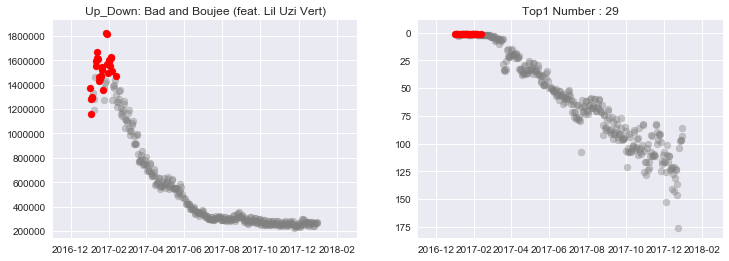

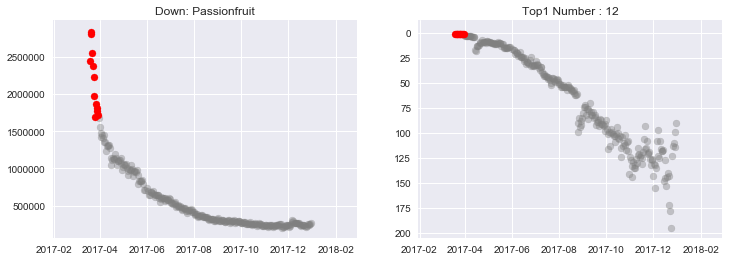

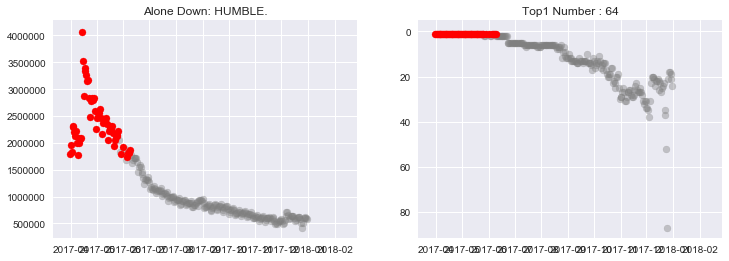

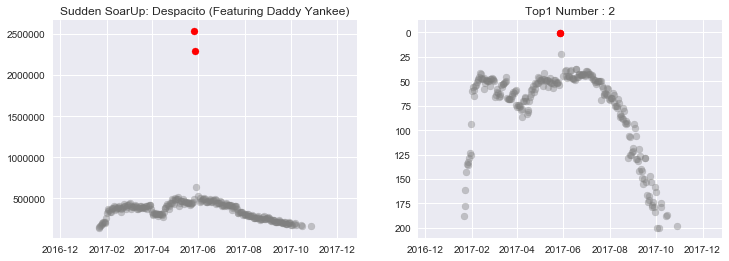

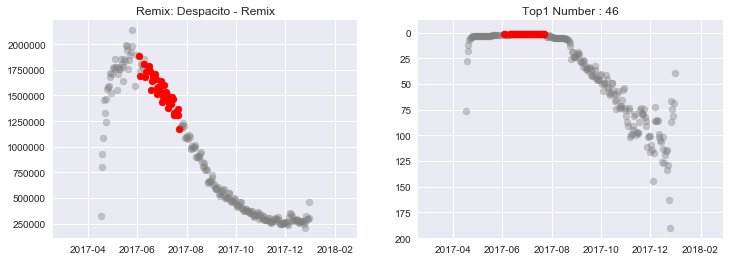

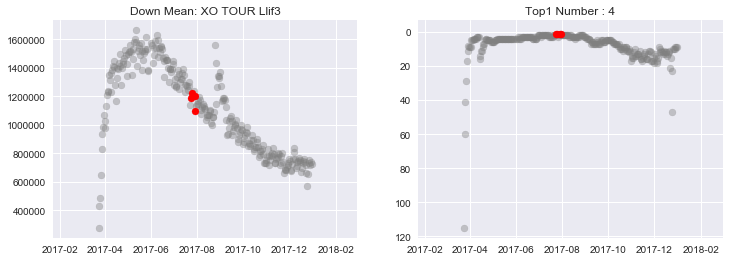

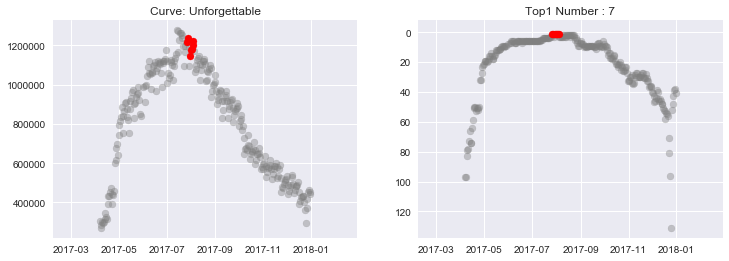

In [9]:
type_of_graph = {0: 'Up_Down', 2:'Down',3:'Alone Down', 4:'Sudden SoarUp', 5: 'Remix', 6:'Down Mean', 8:'Curve'}
for key, type_ in type_of_graph.items():
    draw_stream_pos(us_unique_song,key, type_)

1st graph: Up_Down - A general form, stream increased then decreased smoothly
2nd graph: Down - Popularity of the singer, a song even far soar up, then decreased.
3rd graph: Alone_Down - No competition. The song reached 4 million, keeps status over 2 million
4th graph: Sudden SoarUp - Broadcast Power? 
5th graph: Remix - of the old version
6th graph: Down Mean - The Top rankers Stream number decreased
7th graph: Curve - Step by step increase in stream to top, then decrease smoothly

## 2. Song Charasteristic All World

#### #1. Peek-A-Boo! Red Velvet

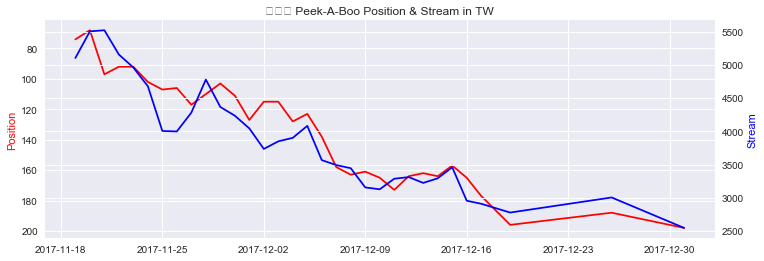

In [10]:
df_tw = df_train.loc[df_train['Region'] == 'tw',:]
df_red = df_tw.loc[(df_tw['Artist'] == 'Red Velvet'),:]
track_red = df_red['Track Name'].unique()
df_red_track0 = df_red.loc[df_red['Track Name'] == track_red[3], :]
plt.figure(figsize = (12,4))
ax = plt.subplot(1,1,1)
ax.set_ylabel('Position', color = 'red')
ax.plot(df_red_track0['Date'], df_red_track0['Position'], 'r-')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.set_ylabel('Stream', color = 'blue')
ax2.plot(df_red_track0['Date'], df_red_track0['Streams'], 'b-')
plt.title(track_red[3] + ' Position & Stream in TW')
plt.show()

Hit the highest position first week. As time goes by, the position and the stream count of the song decreases.

In [11]:
df_red = df_train.loc[df_train['Artist'] == 'Red Velvet', :]
print('Unique Number of Col Values in Red Velvet')
df_red.apply(pd.Series.nunique)

Unique Number of Col Values in Red Velvet


Position       162
Track Name       7
Artist           1
Streams        569
URL              7
Date           172
Region           6
month            9
day             31
dayofweek        7
Region_full      6
dtype: int64

Track Name linked to URL, yet URL starts at different number.
  
Find the position according to Region_full.

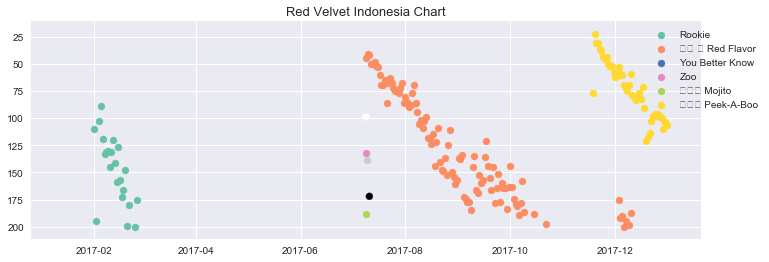

In [13]:
red_popular_region = df_red.loc[df_red['Region'] == 'id',:]
track_lst = red_popular_region['Track Name'].unique()
color = sns.color_palette('Set2', len(track_lst))
plt.figure(figsize = (12,4))
ax = plt.subplot(1,1,1)
i = 0
for track in track_lst:
    ix = red_popular_region['Track Name'] == track
    ax.scatter(x = red_popular_region.loc[ix,'Date'].values, y = red_popular_region.loc[ix,'Position'].values, c = color[i], label = track)
    i += 1
ax.invert_yaxis()
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title('Red Velvet Indonesia Chart', fontsize = 13)
plt.show()

Indonesia is the most popular country for Red Velvet in the Data set.
Peek-A-Boo opened on 2017 Nov, one yellow point(Peek-A-Boo) appeared on 2017.07. Data not correct.  
 
2017.11~2018.01, songs can rise if the artist releases a new song. Once 'Red Flavor' released, their other songs, 'Blue : You Better Know', 'Purple: Zoo', 'Green: Mojito' appeared one time.

## 2. Top Chart : Ed Sheeran

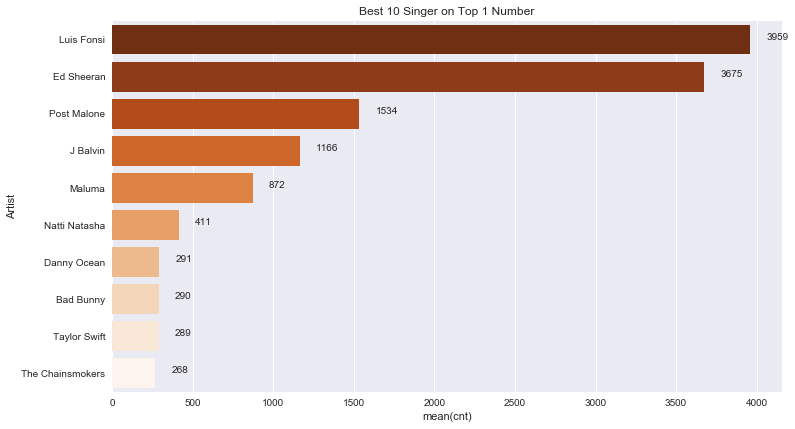

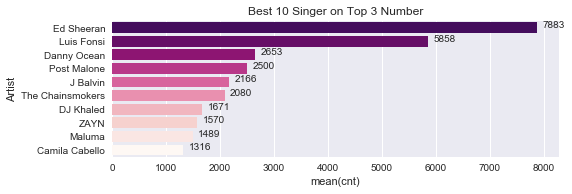

In [14]:
top_chart = df_train.loc[df_train['Position'] == 1, 'Artist'].value_counts()
top_chart = top_chart.to_frame().reset_index()
top_chart.columns = ['Artist', 'cnt']

plt.figure(figsize = (12,15))
ax = plt.subplot(2,1,1)
sns.barplot(data = top_chart.iloc[:10,:], y = 'Artist', x = 'cnt', ax = ax, palette = plt.cm.Oranges(np.linspace(1, 0, 10)))
for i in range(10):
    ax.text(top_chart.loc[i,'cnt']+100, i, str(top_chart.loc[i,'cnt']), fontsize = 10)
ax.set_title('Best 10 Singer on Top 1 Number')
plt.show()

top_chart = df_train.loc[df_train['Position'] <= 3, 'Artist'].value_counts()
top_chart = top_chart.to_frame().reset_index()
top_chart.columns = ['Artist', 'cnt']

ax = plt.subplot(2,1,2)
sns.barplot(data = top_chart.iloc[:10,:], y = 'Artist', x = 'cnt', ax = ax, palette = plt.cm.RdPu(np.linspace(1, 0, 10)))
for i in range(10):
    ax.text(top_chart.loc[i,'cnt']+100, i, str(top_chart.loc[i,'cnt']), fontsize = 10)
ax.set_title('Best 10 Singer on Top 3 Number')
plt.show()

In [16]:
df_sh = df_train.loc[df_train['Artist'] == 'Ed Sheeran',:]

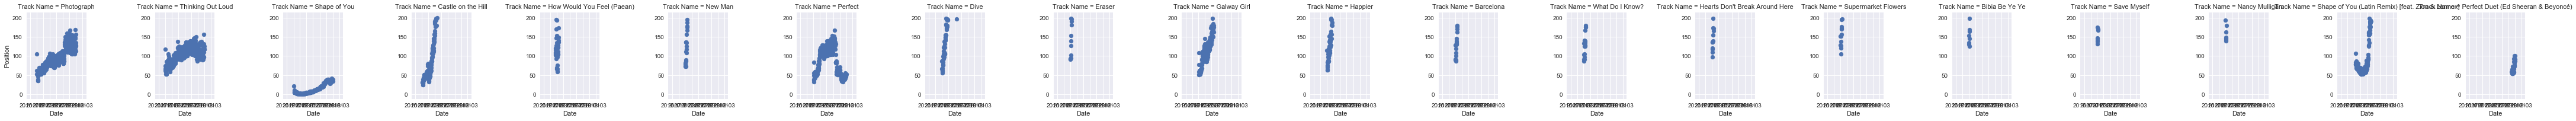

In [17]:
sh_region = df_sh['Region'].unique()
sh_ec = df_sh.loc[df_sh.Region == sh_region[0], :]
g = sns.FacetGrid(data = sh_ec, col = 'Track Name')
g.map(plt.scatter, 'Date', 'Position')
plt.show()

Many popular songs.

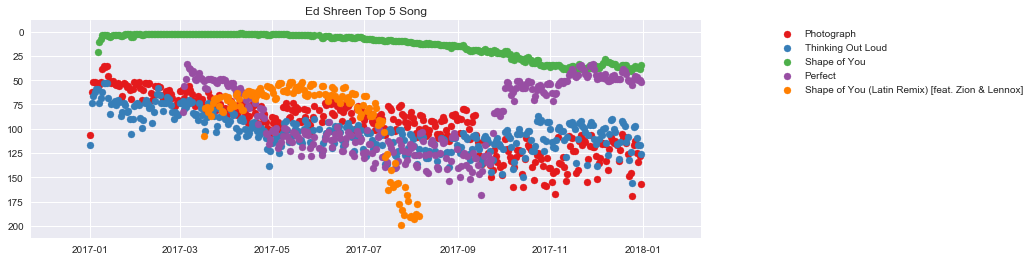

In [19]:
five_sh = sh_ec['Track Name'].value_counts()[:5].index.tolist()
plt.figure(figsize = (12,4))
ax = plt.subplot(1,1,1)
color = sns.color_palette('Set1',5)
i = 0
for track in five_sh:
    ix = sh_ec['Track Name'] == track
    ax.scatter(sh_ec.loc[ix, 'Date'].values, sh_ec.loc[ix,'Position'].values, c = color[i], label = track)
    i += 1
ax.invert_yaxis()
ax.legend(bbox_to_anchor = (1.1,1))
plt.title('Ed Shreen Top 5 Song')
plt.show()

### How do you get a number one song? 
##### Have lots of other popular songs.

## 3. Seaonal Song

???

In [20]:
def get_Season(month):
    if month in (1,2,11,12):
        season = 'winter'
    elif month in (3,4,5):
        season = 'spring'
    elif month in (6,7,8):
        season = 'summer'
    else:
        season = 'autumn'
    return season

df_train['season'] = df_train['month'].apply(get_Season)
tmp_season = df_train[['Track Name', 'Streams', 'Position']].groupby(df_train['season'])

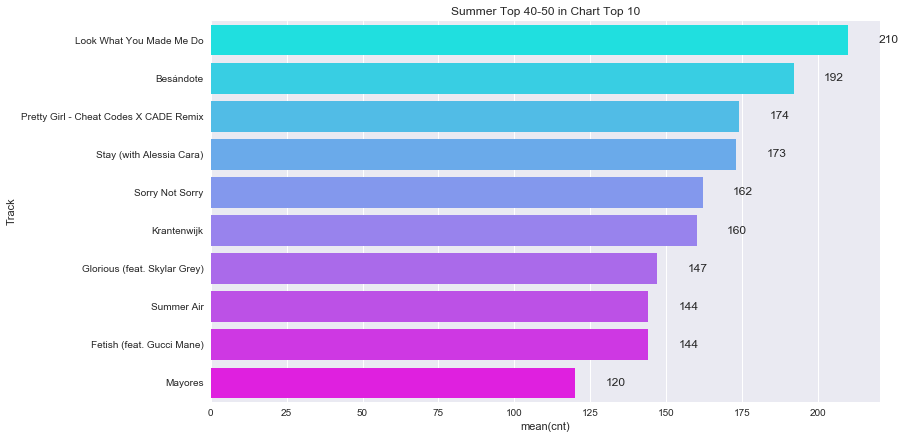

In [22]:
df_spring = tmp_season.get_group('summer')
spring_10 = df_spring[['Track Name', 'Position']].loc[df_spring.Position <= 10, :]
spring_cnt_10 = spring_10['Track Name'].value_counts().to_frame().reset_index()
spring_cnt_10.columns = ['Track', 'cnt']
plt.figure(figsize = (12,7))
ax = plt.subplot(1,1,1)
tmp_spring_10 = spring_cnt_10.iloc[np.arange(40,50),:]
tmp_spring_10.reset_index(drop=  True, inplace = True)
sns.barplot(y = 'Track', x = 'cnt', data = tmp_spring_10, ax = ax, palette = plt.cm.cool(np.linspace(0,1,10)))
for i in range(10):
    ax.text(tmp_spring_10.loc[i,'cnt']+10, i, str(tmp_spring_10.loc[i,'cnt']), va = 'center')
ax.set_title('Summer Top 40-50 in Chart Top 10')
plt.show()

Summer Air

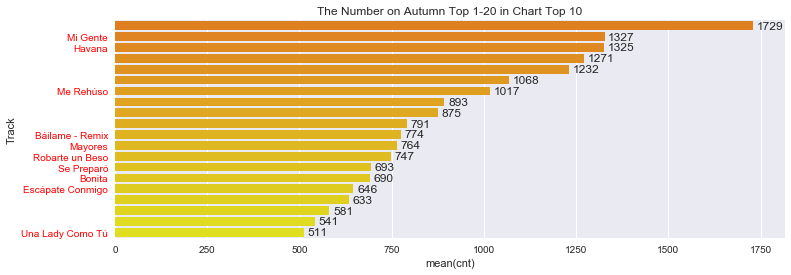

In [24]:
df_spring = tmp_season.get_group('autumn')
spring_10 = df_spring[['Track Name', 'Position']].loc[df_spring.Position <= 10, :]
spring_cnt_10 = spring_10['Track Name'].value_counts().to_frame().reset_index()
spring_cnt_10.columns = ['Track', 'cnt']
plt.figure(figsize = (12,4))
ax = plt.subplot(1,1,1)
tmp_spring_10 = spring_cnt_10.iloc[np.arange(0,20),:]
tmp_spring_10.reset_index(drop=  True, inplace = True)
sns.barplot(y = 'Track', x = 'cnt', data = tmp_spring_10, ax = ax, palette = plt.cm.autumn(np.linspace(0.5, 1, 20)))
for i in range(20):
    ax.text(tmp_spring_10.loc[i,'cnt']+10, i, str(tmp_spring_10.loc[i,'cnt']), va = 'center')
spanish = set([1,2,6,10,11,12,13,14,15,19])
track_name = tmp_spring_10.Track.values.tolist()
ax.set_yticklabels([track_name[i] if i in spanish else '' for i in range(20)], color = 'red')
ax.set_title('Autumn Top 1-20 in Chart Top 10')
plt.show()

Autumn is Spanish season among top 20, 10 song
(Mi Gente, Havana, Me Rehuso, Bailame, Mayores, Robarte un Beso, Se Preparo, Bonita, Escapate Conmigo, Unda Lady Como Tu) 

Emotional Song
Search emotional words.

In [26]:
df_train['lower_Track'] = df_train['Track Name'].apply(lambda word: word.lower())
us_song = df_train['lower_Track'].loc[df_train.Region == 'us']
unique_Song = pd.DataFrame(us_song.unique(), columns = ['track'])
unique_Song['track_set'] = unique_Song['track'].apply(lambda title: set(title.split(' ')))
emotion_dict = {}
for row in positive_word.iterrows():
    char = row[1]['char']
    col_name = 'em_' + char
    char_set = row[1]['word_set']
    emotion_dict[col_name] = unique_Song['track_set'].apply(lambda title_set: 0 if len(title_set & char_set) == 0 else 1)
unique_Song = pd.concat([unique_Song,pd.DataFrame.from_dict(emotion_dict, orient = 'columns')], axis = 1)
unique_Song.drop('track_set', axis = 1, inplace = True)

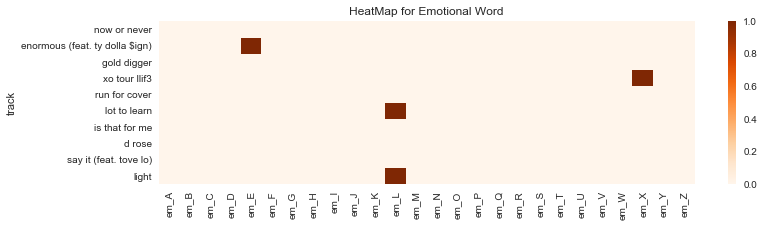

In [27]:
tmp_emotion = unique_Song.set_index('track')
plt.figure(figsize = (12,3))
ax = plt.subplot(1,1,1)
sns.heatmap(tmp_emotion.sample(10), cmap = plt.cm.Oranges, ax = ax)
ax.set_title('HeatMap for Emotional Word')
plt.show()

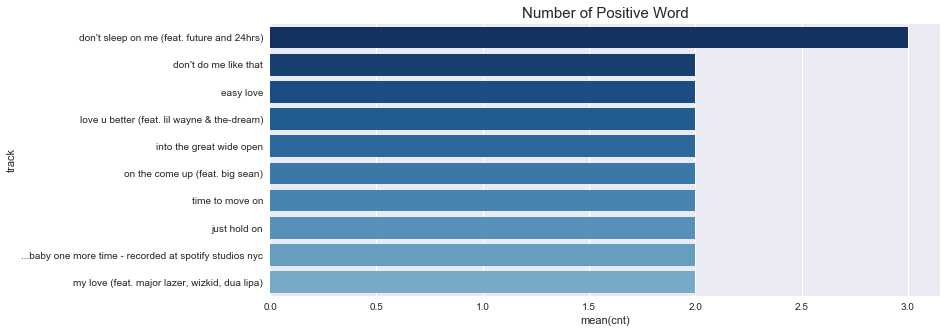

In [28]:
tmp_emotion_sum = tmp_emotion.sum(axis = 1).to_frame().reset_index()
tmp_emotion_sum.columns = ['track', 'cnt']
tmp_emotion_sum.sort_values('cnt', inplace = True, ascending = False)
plt.figure(figsize = (12,5))
ax = plt.subplot(1,1,1)
sns.barplot(x = 'cnt', y = 'track', data = tmp_emotion_sum.head(10), palette = plt.cm.Blues(np.linspace(1,0.5,10)), ax = ax)
ax.set_title("Number of Positive Word", size = 15)
plt.show()

In [29]:
print('# Song in US Chart: ', tmp_emotion_sum.shape[0])
print('The Song contains of English Positive Word: ',(tmp_emotion_sum.cnt != 0).sum())
print('The Song Not contains of English Positive Word: ',(tmp_emotion_sum.cnt == 0).sum())
print('--------------------------------------------------------------------------------------------')
us_chart = df_train.loc[(df_train.Region == 'us'),:]
top30_song = us_chart.loc[us_chart.Position <= 30, 'Track Name'].unique()
top30_song = pd.DataFrame(top30_song, columns = ['Track Name'])
top30_song['track'] = top30_song['Track Name'].apply(lambda track: track.lower())
top30_emotion_song = tmp_emotion_sum.merge(top30_song, how = 'right', on = 'track').fillna('None')
#top30_emotion_song.drop('track', axis = 1, inplace = True)
print('# Top 30 Song: ', top30_emotion_song.shape[0])
print('The 30 Song contains of English Positive Word: ',(top30_emotion_song.cnt != 0).sum())
print('The 30 Song Not contains of English Positive Word: ',(top30_emotion_song.cnt == 0).sum())

# Song in US Chart:  1593
The Song contains of English Positive Word:  406
The Song Not contains of English Positive Word:  1187
--------------------------------------------------------------------------------------------
# Top 30 Song:  299
The 30 Song contains of English Positive Word:  66
The 30 Song Not contains of English Positive Word:  233


20~25% of songs in the total or top 30 US Chart contain emotionals words

## 3. Song Chraractertistic w/ Counry 

#### #1. Japane Chart
Every country has songs written in their language, but Japan data is werid.

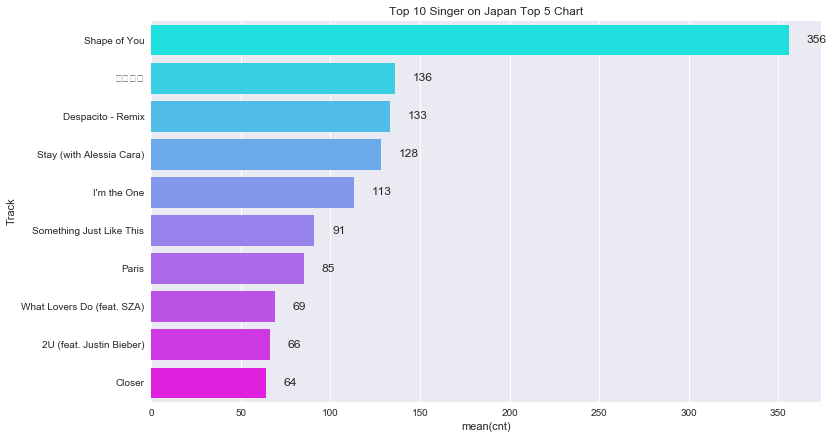

2nd song:  打上花火
Top 10 Singer on Japan Top 5 Lists
['The Chainsmokers', 'Ed Sheeran', 'Zedd', 'Luis Fonsi', 'DJ Khaled', 'POWERS', 'David Guetta', 'DAOKO×米津玄師', 'Maroon 5']


In [31]:
df_japan = df_train.loc[df_train.Region == 'jp',:]
jp_10 = df_japan[['Track Name', 'Position']].loc[df_japan.Position <= 5, :]
jp_cnt_10 = jp_10['Track Name'].value_counts().to_frame().reset_index()
jp_cnt_10.columns = ['Track', 'cnt']
plt.figure(figsize = (12,7))
ax = plt.subplot(1,1,1)
tmp_jp_10 = jp_cnt_10.iloc[np.arange(0,10),:]
tmp_jp_10.reset_index(drop=  True, inplace = True)
sns.barplot(y = 'Track', x = 'cnt', data = tmp_jp_10, ax = ax, palette = plt.cm.cool(np.linspace(0,1,10)))
ax.set_yticklabels(tmp_jp_10['Track'].values)
for i in range(10):
    ax.text(tmp_jp_10.loc[i,'cnt']+10, i, str(tmp_jp_10.loc[i,'cnt']), va = 'center')
ax.set_title('Top 10 Singer on Japan Top 5 Chart')
plt.show()
print('2nd song: ',tmp_jp_10.loc[1,'Track'])
print('Top 10 Singer on Japan Top 5 Lists')
print(df_japan.loc[df_japan['Track Name'].isin(tmp_jp_10.Track), 'Artist'].unique().tolist())

#### The majority of Spotify streams in Japan are not written in Japanese. 
Why are most of the songs written by English?  

One song, '打上花火(Fireworks)' in the chart is a Japanese song.

#### 2. Correlation US with other Chart

In [33]:
date = df_train.Date.sample(1).values[0]
region_pos = df_train.loc[df_train.Date == date, ['Position','Track Name','Region']]
region_pos = region_pos.loc[region_pos.Position <= 30, :]
region_grp = region_pos.groupby('Region')
us_pos = region_grp.get_group('us')
us_track = set(us_pos['Track Name'].unique().tolist())
total_track = len(us_track)
#무관심 정도: Track Number of the Intersection == 0
#지난 10일간: 무관심정도
#관심 정도: Among intersected track, sum(abs(USchart - Con chart)) -> 0 simliar impact
#관심 정도: Among intersected track, sum(squared(USchart - Con chart)) -> Larger Severeal difference
#관심 정도: Among intersected track, sum(with same sign (US Chart- Con Chart) of squared(USChart - Con chart))
#-> Many -: Con is usually upper, Many +: Con is usually downer
country_info = []
for i, con in enumerate(region_pos.Region.unique()):
    if con == 'us':
        continue
    con_grp = region_grp.get_group(con)
    con_track = set(con_grp['Track Name'].unique().tolist())
    inter_track = us_track & con_track
    num_interest = len(inter_track)
    if num_interest == 0:
        con_dict = {'un_track': total_track - num_interest, 'int_track': num_interest, 'abs_diff':-1, 'sq_diff':-1,
        'sq_diff_min':-1, 'sq_diff_plus':-1}
    else:
        con_dict = {'un_track': total_track - num_interest, 'int_track': num_interest}
        track_dict = {}
        for track in inter_track:
            dif = us_pos.loc[us_pos['Track Name'] == track, 'Position'].values[0] - con_grp.loc[con_grp['Track Name'] == track, 'Position'].values[0]
            track_dict[track] = [dif, np.sign(dif)]
            
        track_dict_pd = pd.DataFrame.from_dict(track_dict, orient = 'index')
        track_dict_pd.columns = ['dif', 'sign']
        con_dict['abs_diff'] = track_dict_pd.dif.abs().sum()
        con_dict['sq_diff'] = np.power(track_dict_pd.dif,2).sum()
        con_dict['sq_diff_min'] = np.power(track_dict_pd.dif.loc[track_dict_pd.sign == -1],2).sum()
        con_dict['sq_diff_plus'] = np.power(track_dict_pd.dif.loc[track_dict_pd.sign == 1],2).sum()
    con_dict['country'] = con
    con_dict['trackNum'] = total_track
    country_info.append(con_dict)

In [34]:
country_df = pd.DataFrame.from_dict(country_info, orient = 'columns')
#country_df.set_index('country', inplace = True)
country_df['full_name'] = country_df['country'].map(dict_count)
country_df = country_df.reindex(['full_name','un_track', 'int_track', 'abs_diff', 'sq_diff', 'sq_diff_min', 'sq_diff_plus', 'country', 'trackNum'])
country_df.sort_values('int_track', ascending = False, inplace = True)
country_df.head(7)

,abs_diff,country,int_track,sq_diff,sq_diff_min,sq_diff_plus,trackNum,un_track,full_name
full_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
un_track,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_track,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abs_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sq_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sq_diff_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sq_diff_plus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Modeling

In [35]:
#### 1. Shape of You, Setting A Basic Paramter: ARIMA Modeling for Stream

In [36]:
df_train = pd.read_csv('./input/data.csv')
df_train.dropna(inplace = True)
df_train['Date'] = pd.to_datetime(df_train['Date'])

df_us = df_train.loc[df_train.Region == 'us',:]
shape_of_you = df_us[['Date','Streams']].loc[df_us['Track Name'] == 'Shape of You',:]
shape_of_you.set_index('Date', inplace = True)

In [37]:
shape_of_you_tmp = shape_of_you.copy()

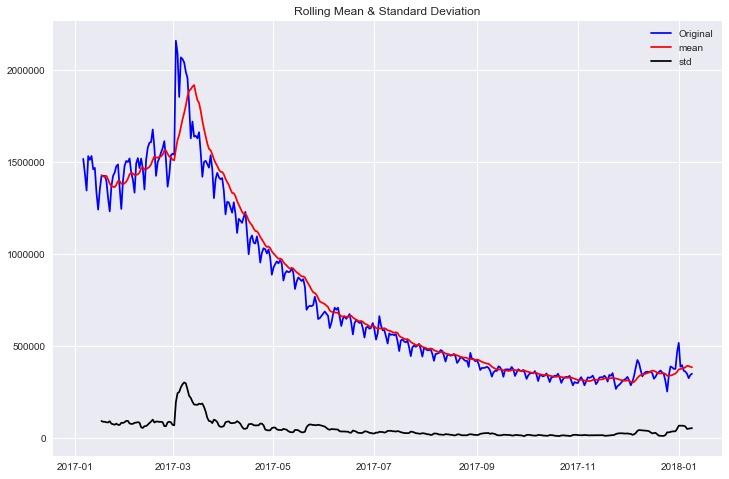

In [38]:
rollmean = pd.DataFrame.rolling(shape_of_you, window = 12).mean()
rollstd = pd.DataFrame.rolling(shape_of_you, window = 12).std()

fig = plt.figure(figsize=(12, 8))
plt.plot(shape_of_you, color = 'blue', label = 'Original')
plt.plot(rollmean, color = 'red', label = 'mean')
plt.plot(rollstd, color = 'k', label = 'std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [41]:
# Dickey_Fuller Test

In [40]:
shape_of_you_tmp = shape_of_you.copy()
p_value = dict()
for tf in ['raw', 'log']:
    if tf == 'log':
        shape_of_you_tmp = np.log1p(shape_of_you_tmp)
        continue
    for dep in [0,1,2]:
        if dep == 0:
            tmp = shape_of_you_tmp.values
        elif dep == 1:
            tmp = shape_of_you_tmp.values.cumsum()
        elif dep == 2:
            tmp = shape_of_you_tmp.values.cumsum().cumsum()
            
        for reg in ['c', 'ct', 'ctt', 'nc']:
            dftest = adfuller(np.ravel(tmp), autolag='AIC', regression = reg)
            dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
            p_value[tf+'_'+reg + '_' + str(dep)] = dfoutput.loc['p-value']

p_value_df = pd.DataFrame([p_value]).T
p_value_df.columns = ['P value']
print(p_value_df[p_value_df.values < 0.05].sort_values('P value'))

            P value
raw_ctt_2  0.001408
raw_ct_1   0.006599
raw_c_1    0.010517


#### "x_y_num"
1. x, Type of Transformation
    In this kernel I skiped out of log since wihout log the model are enough explaining the Y values)
2. y, Parameter AR(P), MA(Q)
    (ctt: ' constant + linear and quadratic trend' , ct: 'constant + Local Trend from last few observations' , c: 'constant') 
*constant: Weights per Time Interval from the enitre dataset, e.g. if you have a positive one, the weight brings a positive effect to Y Prediction*
*Trend: Weights from the last few obersvations, e.g. the value reflects the last few tendency.*
*Linear and Qudratic Trend: Complicated Weights from the last few observations, e.g. it was a linear or Qudaratic function.*
3. num, Differencing Order D()

Dickey_Fuller Test says there are that 1 and 2 are effective differencing order.  

Autocorrelation and Partial Correlation Graph with 0,1,2

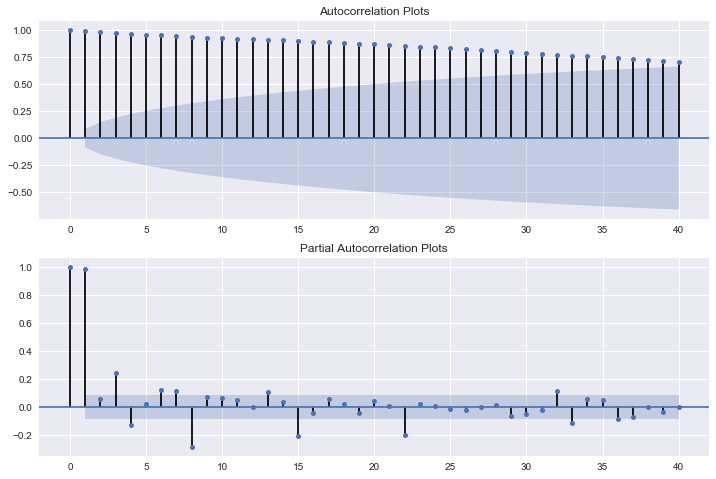

In [42]:
f= plt.figure(figsize = (12,8))
ax1= f.add_subplot(211)
f = plot_acf(shape_of_you, lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('Autocorrelation Plots')
ax2 = f.add_subplot(212)
f = plot_pacf(shape_of_you, lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('Partial Autocorrelation Plots')
plt.show()

If the autocorrelation is steadily high + the number of positive high peak on partial autocorrelation plot << the number of positive high peak on autocorrelation plot  -> then Need a Higher Order

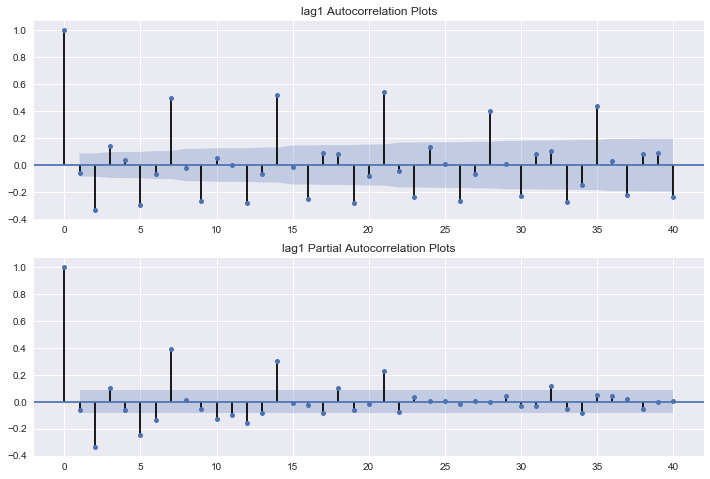

In [44]:
lag1_shape_of_you = shape_of_you - shape_of_you.shift(1)
lag2_shape_of_you = shape_of_you - 2*shape_of_you.shift(1) + shape_of_you.shift(2)
f= plt.figure(figsize = (12,8))
ax1= f.add_subplot(211)
f = plot_acf(lag1_shape_of_you.dropna(inplace = False), lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('lag1 Autocorrelation Plots')
ax2 = f.add_subplot(212)
f = plot_pacf(lag1_shape_of_you.dropna(inplace = False), lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('lag1 Partial Autocorrelation Plots')
plt.show()

The First Lag explained a lot of models. But there are some high peaks that appeared regulary with the interval 7. So the question is, "Are there any Seasonal Impacts?"  
*Although there are some negative peaks, we passed those since those happend irregulary.*

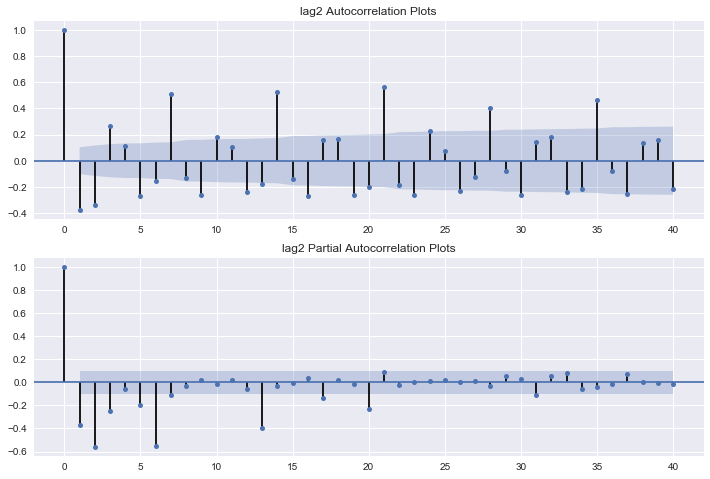

In [46]:
f= plt.figure(figsize = (12,8))
ax1= f.add_subplot(211)
f = plot_acf(lag2_shape_of_you.dropna(inplace = False), lags=40, ax=ax1)
ax1.set_title('lag2 Autocorrelation Plots')

ax2 = f.add_subplot(212)
f = plot_pacf(lag2_shape_of_you.dropna(inplace = False), lags=40, ax=ax2, alpha = 0.05)
ax2.set_title('lag2 Partial Autocorrelation Plots')
plt.show()

There are no advantages for Lag2 rather than Lag1.  
I am skeptical to the negative peaks over 0.5. When the magnitue is under 0.5, it indicated the Difference Order have to be lower.

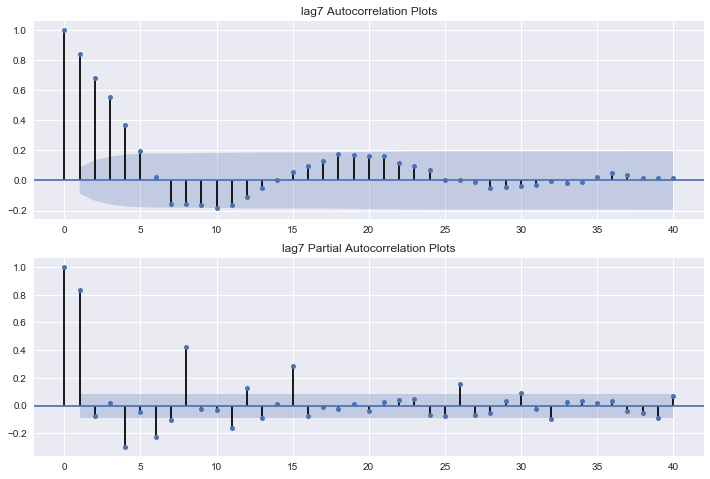

In [47]:
lag7_shape_of_you = shape_of_you - shape_of_you.shift(7)
f= plt.figure(figsize = (12,8))
ax1= f.add_subplot(211)
f = plot_acf(lag7_shape_of_you.dropna(inplace = False), lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('lag7 Autocorrelation Plots')
ax2 = f.add_subplot(212)
f = plot_pacf(lag7_shape_of_you.dropna(inplace = False), lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('lag7 Partial Autocorrelation Plots')
plt.show()

When I only give the week impact, the graphs shows that "the neighborhood power" with the positive peaks under small lags.

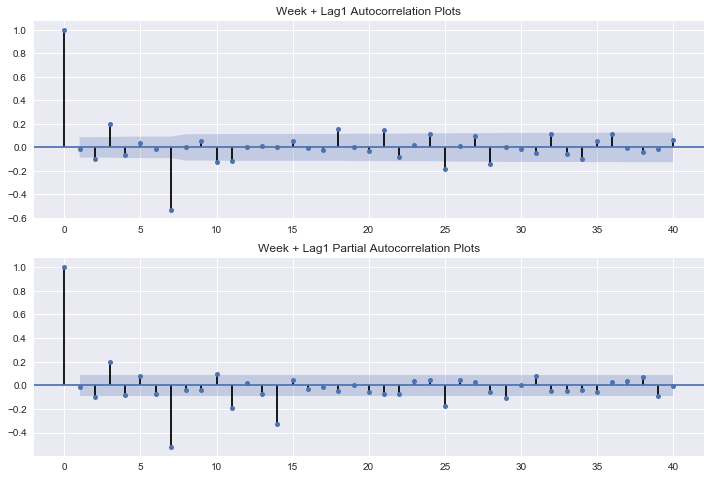

In [48]:
season_diff_shape_of_you = lag1_shape_of_you - lag1_shape_of_you.shift(7)
f= plt.figure(figsize = (12,8))
ax1= f.add_subplot(211)
f = plot_acf(season_diff_shape_of_you.dropna(inplace = False), lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('Week + Lag1 Autocorrelation Plots')
ax2 = f.add_subplot(212)
f = plot_pacf(season_diff_shape_of_you.dropna(inplace = False), lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('Week + Lag1 Partial Autocorrelation Plots')
plt.show()

Better, although there exists some negative peaks. Choosing (1,1,0) x (1,1,0) as a base parameter of ARIMA Seasonal Model

### 2. The best fit model to train data

In [50]:
def get_X(song):
    nrows = song.shape[0]
    num_train = int(nrows * 0.8)
    X_train, X_test = song.iloc[np.arange(0,num_train),:], song.iloc[np.arange(num_train, nrows),:]
    return X_train, X_test, (nrows, num_train)

def mdl_shape(mdl, row_info, name = '(1,1,0)x(1,1,0,7)xtrend t Model',exog = None, portion = 0.5):
    nrows, num_train = row_info
    result = mdl.fit()
    forecast = result.predict(start = int(nrows*portion), end = num_train, dynamic = True, exog = exog)
    X_train['forecast'] = np.hstack([np.zeros((int(nrows*portion)-1)), forecast.values])
    f,ax = plt.subplots(1,1,figsize = (12,4))
    X_train[['Streams','forecast']].plot(ax = ax)
    ax.set_title(name)
    plt.show()

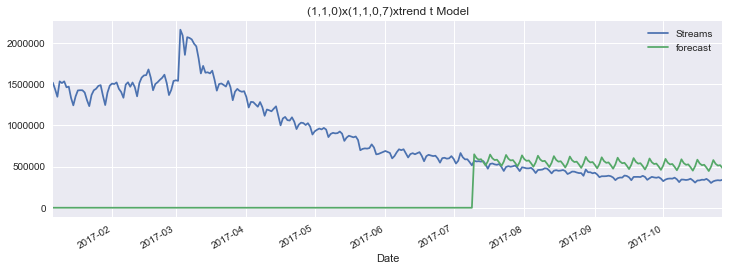

In [51]:
X_train, X_test,row_info = get_X(shape_of_you)
#Current Modl
mdl1 = SARIMAX(X_train, trend = 'n', order=(1,1,0), seasonal_order=(1,1,0,7))
mdl_shape(mdl1,row_info)

Bad model. The chosen basic parameter is not reflecting "Trend", which comes from the third parameter of both left and right bracket. Added to 1 for third slots and delete the first slots since first and third collide with each other.

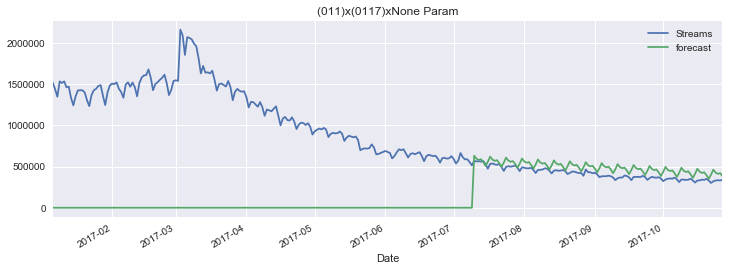

In [54]:
X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl2 = SARIMAX(X_train, trend = 'n', order=(0,1,1), seasonal_order=(0,1,1,7))
mdl_shape(mdl2, row_info,name = '(011)x(0117)xNone Param')

Slightly better since MV(the last term of (x,y,z) pair) reflects the near power than AR, but still bad. Dukey_Fuller Test indicated raw_ct_2, "Difference 2 and Constant + Trend" is the best choice.

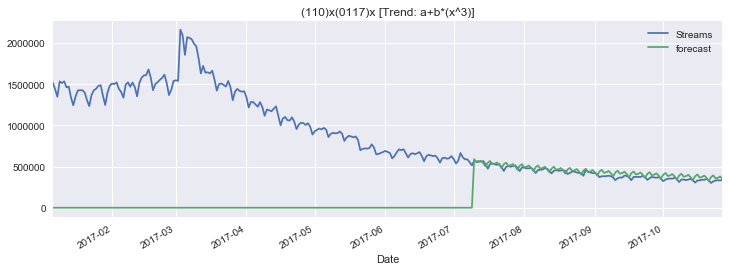

In [55]:
X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl2 = SARIMAX(X_train, trend = [1,0,0,1], order=(1,1,0), seasonal_order=(0,1,1,7))
mdl_shape(mdl2, row_info,name = '(110)x(0117)x [Trend: a+b*(x^3)]')
#mdl2 = SARIMAX(X_train, trend = [1,0,0,1], order=(1,1,0), seasonal_order=(0,1,1,7))
#mdl_shape(mdl2, name = '(110)x(0117)x [Trend: a1 + a2*(x^3)]')

Best. The Constant term comes from (110), the first slot 1 of the left part  + (The trends comes from (0,1,1), the last element 1 of the right part * Trend (3 powers))

In [56]:
### 3.Test Prediction

In [57]:
def prediction_mdl(mdl,row_info, X_test, name = '', exog = None):
    nrows, num_train = row_info
    result = mdl2.fit()

    forecast = result.predict(start = num_train-1, end = nrows, dynamic = True, exog = exog)
    X_test['forecast'] = forecast[2:].values

    f,ax = plt.subplots(1,1,figsize = (12,4))
    X_test[['Streams','forecast']].plot(ax = ax)
    ax.set_title(name)
    plt.show()

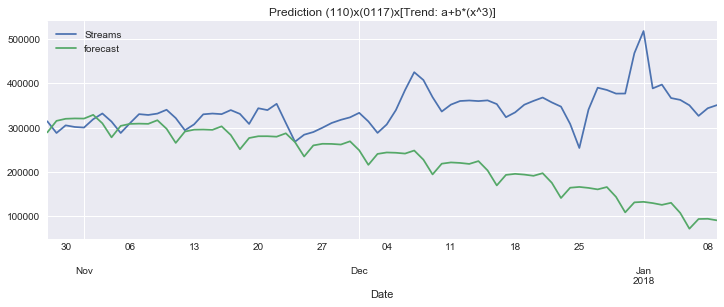

In [58]:
X_train, X_test, row_info = get_X(shape_of_you)
mdl2 = SARIMAX(X_train, trend = [1,0,0,1], order=(1,1,0), seasonal_order=(0,1,1,7))
prediction_mdl(mdl2, row_info, X_test, name = 'Prediction (110)x(0117)x[Trend: a+b*(x^3)]')

Not good, the streams of the song suddenly escaped the last pattern decreasing. So the constant term is bad for this prediction. But if we delete constant trend and decrease the power of trend (3->1)!

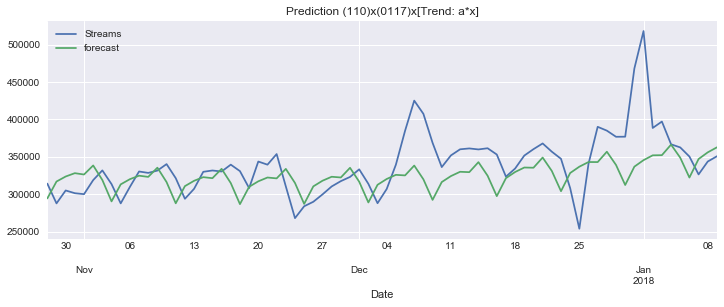

In [59]:
X_train, X_test,row_info = get_X(shape_of_you)
mdl2 = SARIMAX(X_train, trend = [0,1,0,0], order=(1,1,0), seasonal_order=(0,1,1,7))
prediction_mdl(mdl2, row_info, X_test, name = 'Prediction (110)x(0117)x[Trend: a*x]')

Okay

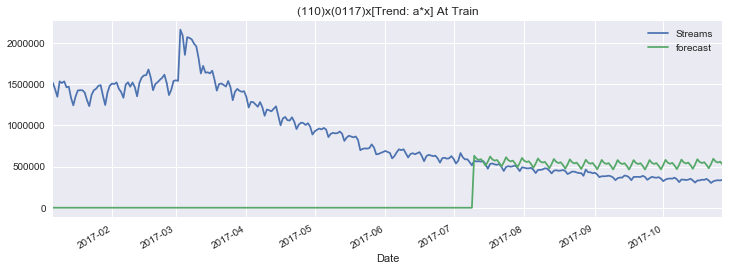

In [62]:
X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl2 = SARIMAX(X_train, trend = [0,1,0,0], order=(1,1,0), seasonal_order=(0,1,1,7))
mdl_shape(mdl2, row_info,name = '(110)x(0117)x[Trend: a*x] At Train')

Bad for train set. Change, adding X variables?

#### 4. With X variables, exogenous SARIMAX

In [64]:
def tf_song_feature(song_feature):
    song_feature.drop(['id'], axis = 1, inplace= True)
    song_feature.rename(columns = {'name': 'Track Name', 'artists': 'Artist'}, inplace= True)
    return song_feature

song_feature = pd.read_csv('./input/featuresdf.csv')
song_feature = tf_song_feature(song_feature)
exog = song_feature.loc[0,:].values[2:]

In [65]:
song_feature.head(1)

,Track Name,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.581,0.0,0.0931,0.931,95.977,233713.0,4.0


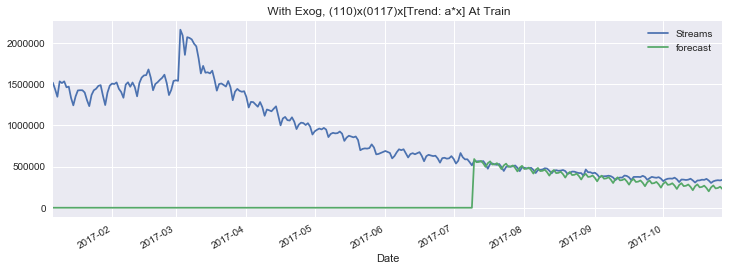

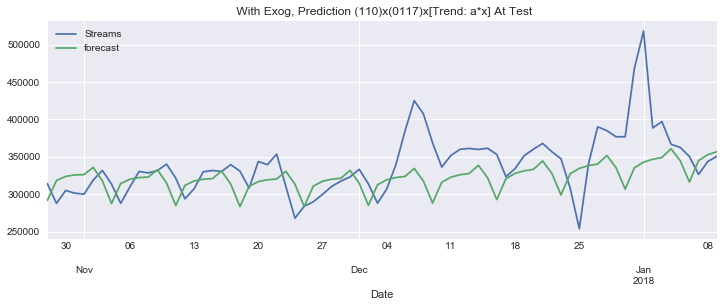

In [66]:
exog = exog.astype(float)
X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl2 = SARIMAX(endog = X_train,exog = np.array([exog for i in range(X_train.shape[0])]), trend = [0,1,0,0], order=(1,1,0), seasonal_order=(0,1,1,7))
mdl_shape(mdl2, row_info,name = ' With Exog, (110)x(0117)x[Trend: a*x] At Train', exog = exog.reshape(1,13))
X_train, X_test,row_info = get_X(shape_of_you)
prediction_mdl(mdl2, row_info, X_test, name = ' With Exog, Prediction (110)x(0117)x[Trend: a*x] At Test', exog = np.array([exog for i in range(75)]))

#### 5. Additional Test to reach limitation of ARIMA

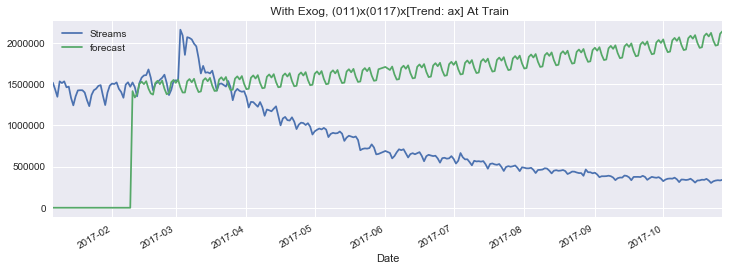

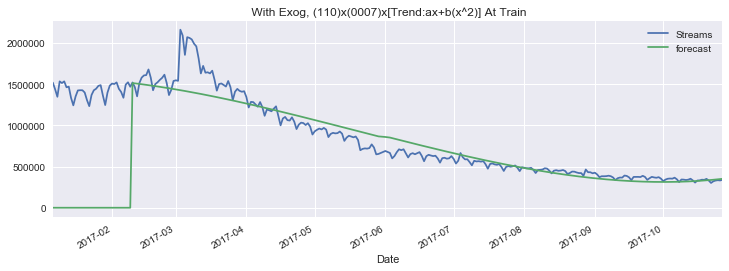

In [68]:
X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl3 = SARIMAX(endog = X_train,exog = np.array([exog for i in range(X_train.shape[0])]), trend = 't', order=(0,1,1), seasonal_order=(1,1,0,7))
mdl_shape(mdl3, row_info,name = ' With Exog, (011)x(0117)x[Trend: ax] At Train', exog = exog.reshape(1,13), portion = 0.1)

X_train, X_test, row_info = get_X(shape_of_you)
#Current Modl
mdl3 = SARIMAX(endog = X_train,exog = np.array([exog for i in range(X_train.shape[0])]), trend = [0,1,1], order=(1,1,0), seasonal_order=(0,0,0,7))
mdl_shape(mdl3, row_info,name = ' With Exog, (110)x(0007)x[Trend:ax+b(x^2)] At Train', exog = exog.reshape(1,13), portion = 0.1)

Predicted the power peak up, ARIMA totally dominated or ignored the peak up on all equations, known limtation for ARIMA.

In [ ]:
# hic sunt dracones

In [ ]:
def merge_all():
    df_train, positive_word, song_feature = call_df()
    df_us = df_train.loc[df_train.Region == 'us',:]
    
    df_us.drop(['URL', 'day', 'dayofweek'], axis = 1, inplace = True)
    df_tr_us, df_tt_us = df_us.loc[df_us.month < 11,:], df_us.loc[df_us.month > 10,:]
    df_tr_us.drop('month', axis = 1, inplace=True)
    df_tt_us.drop('month', axis = 1, inplace=True)
    all_df = df_tr_us[['Track Name', 'Artist']].groupby(['Track Name', 'Artist']).size().reset_index()[['Track Name', 'Artist']]
    all_tt = df_tt_us[['Track Name', 'Artist']].groupby(['Track Name', 'Artist']).size().reset_index()[['Track Name', 'Artist']]
    tr_list =[all_df, rank_df(df_tr_us), emotion_song(df_tr_us, positive_word), rank_interval(df_tr_us), None]
    all_df = merge_df(*tr_list)
    
    tt_list =[all_tt, rank_df(df_tt_us), emotion_song(df_tt_us, positive_word), rank_interval(df_tt_us), None]
    all_tt = merge_df(*tt_list)
    
    return all_df, all_tt

def test_fitted_to_train(all_df, all_tt):
    artist_power = ['Position_min', 'Position_max', 'Streams_min',
       'Streams_max', 'Pos_0', 'Pos_1', 'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5',
       'Pos_6', 'St_0', 'St_1', 'St_2', 'St_3', 'St_4', 'St_5', 'St_6',
       'd_interval']
    artist_power_df = all_df.groupby('Artist').agg({col : ['mean', 'median'] for col in artist_power})

    artist_power_df.columns = [col[0] + '_' + col[1] for col in artist_power_df.columns]
    artist_power_df = artist_power_df.dropna()
    artist_power_df = artist_power_df.astype(int)

    all_tt.drop(artist_power, axis =1, inplace = True)

    artist_power_df.reset_index(inplace=  True)
    all_tt = all_tt.merge(artist_power_df, on = ['Artist'], how = 'left')
    return all_tt

In [ ]:
def call_df():
    
    df_train = pd.read_csv('../input/spotifys-worldwide-daily-song-ranking/data.csv')
    positive_word = pd.read_excel('../input/positive-words/positive_words.xlsx', header = None)
    df_feature = pd.read_csv('../input/top-tracks-of-2017/featuresdf.csv')
    positive_word.columns = ['char', 'word_set']
    positive_word['word_set'] = positive_word['word_set'].apply(lambda r: set([word.strip().lower() for word in r.split(',')]))
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_train = df_train.loc[df_train.Date.dt.year == 2017,:]
    df_train['month'] = df_train.Date.dt.month
    df_train['day'] = df_train.Date.dt.day
    df_train['dayofweek'] = df_train.Date.dt.dayofweek
    df_train.dropna(inplace = True)
    return df_train, positive_word, df_feature

def merge_df(all_df, rank_df, emotion_song, rank_interval, song_feature = None, ):
    all_df = pd.merge(all_df, rank_df, on = ['Track Name', 'Artist'], how = 'left')
    all_df = pd.merge(all_df, rank_interval, on = ['Track Name', 'Artist'], how = 'left')
    all_df = pd.merge(all_df, emotion_song, on = ['Track Name'], how = 'left')
    if song_feature is not None:
        all_df = pd.merge(all_df, song_feature, on = ['Track Name', 'Artist'], how = 'left')
    return all_df

In [ ]:
def rank_df(df_us, term = range(0,7)):
    grp_us = df_us.groupby(['Artist','Track Name'])
    first_pos = grp_us['Position', 'Streams'].nth(list(term)).reset_index()
    day_lst = list(map(str, term))
    pos_lst = ['Pos_'+day  for day in day_lst]
    st_lst = ['St_'+day  for day in day_lst]

    i,n = 0, first_pos.shape[0]
    df_list = []
    while i < n:
        first, singer, track = i, first_pos.loc[i, 'Artist'], first_pos.loc[i, 'Track Name']
        cur_pos_st = {'Artist':singer ,'Track Name': track}
    
        while i < n and singer == first_pos.loc[i, 'Artist'] and track == first_pos.loc[i, 'Track Name']:
            cur_pos_st[pos_lst[i-first]] = first_pos.loc[i, 'Position']
            cur_pos_st[st_lst[i-first]] = first_pos.loc[i, 'Streams']
            i += 1
        df_list.append(cur_pos_st)
    
    track_pos_st = pd.DataFrame(df_list)
    track_pos_st[pos_lst]  =  track_pos_st[pos_lst].fillna(201)
    track_pos_st[st_lst] = track_pos_st[st_lst].fillna(0)
    
    track_min_max = grp_us.agg({col : ['min', 'max'] for col in ['Position', 'Streams']}).reset_index()
    track_min_max.columns = [col[0]+'_'+col[1] if col[1] else col[0] for col in track_min_max.columns]
    track_rank = track_min_max.merge(track_pos_st, on = ['Artist','Track Name'], how = 'left')
    numerical_num = track_rank.select_dtypes(exclude = ['object']).columns
    track_rank[numerical_num] = track_rank[numerical_num].astype(int)
    return track_rank

In [ ]:
def rank_interval(df_us):
    interval_df = df_us.groupby(['Artist', 'Track Name'])
    interval_df = interval_df.agg({'Date':['max','min']}).reset_index()
    interval_df['d_interval'] = interval_df.loc[:,('Date','max')] - interval_df.loc[:,('Date','min')]
    interval_df['d_interval'] = interval_df['d_interval'].apply(lambda row: str(row).split()[0])
    interval_df.columns = [col[0]+col[1] for col in interval_df.columns]
    interval_df['d_interval'] = interval_df['d_interval'].astype(int)
    interval_df = interval_df.loc[:,['Artist', 'Track Name', 'd_interval']]
    return interval_df

In [ ]:
def emotion_song(df_us, positive_word):
    """
    Return:
        track, em_a, em_b, em_c, ... ,em_z: track is 
    """
    df_us['lower_Track'] = df_us['Track Name'].apply(lambda track: track.lower())
    us_song = pd.DataFrame(df_us['lower_Track'].unique(), columns = ['track'])
    us_song['track_set'] = us_song['track'].apply(lambda title: set(title.split(' ')))
    emotion_dict = {}
    for row in positive_word.iterrows():
        char = row[1]['char']
        col_name = 'em_' + char
        char_set = row[1]['word_set']
        emotion_dict[col_name] = us_song['track_set'].apply(lambda title_set: 0 if len(title_set & char_set) == 0 else 1)
    unique_song = pd.concat([us_song,pd.DataFrame.from_dict(emotion_dict, orient = 'columns')], axis = 1)
    unique_song.drop('track_set', axis = 1, inplace = True)
    tmp_emotion = unique_song.set_index('track')
    tmp_emotion_sum = tmp_emotion.sum(axis = 1).to_frame().reset_index()
    tmp_emotion_sum.columns = ['track', 'cnt']
    unique_song = unique_song.merge(tmp_emotion_sum, on = ['track'], how = 'left')
    unique_df = df_us[['lower_Track', 'Track Name']].groupby(['lower_Track', 'Track Name']).size().reset_index().loc[:, ['lower_Track', 'Track Name']]
    unique_song = unique_df.merge(unique_song, how = 'right', left_on = 'lower_Track', right_on = 'track')
    unique_song.drop(['lower_Track', 'track'], axis = 1, inplace = True)
    
    return unique_song

In [ ]:
# all_df, all_tt = merge_all()
# print('test Set Singer number ', all_tt.Artist.unique())
# print('Intersected Singer number ', len(set(all_tt.Artist.unique()) & set(all_df.Artist.unique())))